<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/tensorflow/HousePricePredictorUsingHuberLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Load and preprocess data

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data()
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

57344/57026 [==============================] - 0s 0us/step


In [3]:
train = np.concatenate((x_train, y_train), axis=1)
test = np.concatenate((x_test, y_test), axis=1)
all = np.concatenate((train, test), axis=0)
scaler = MinMaxScaler((0, 1.0))
all_scaled = scaler.fit_transform(all.reshape((all.shape[0] * all.shape[1], 1))).reshape((all.shape[0], all.shape[1]))

In [4]:
x_train_scaled = all_scaled[:x_train.shape[0], :x_train.shape[1]]
y_train_scaled = all_scaled[:x_train.shape[0], x_train.shape[1]:]
x_test_scaled = all_scaled[x_train.shape[0]:, :x_train.shape[1]]
y_test_scaled = all_scaled[x_train.shape[0]:, x_train.shape[1]:]
assert x_train_scaled.shape == x_train.shape
assert y_train_scaled.shape == y_train.shape
assert x_test_scaled.shape == x_test.shape
assert y_test_scaled.shape == y_test.shape

## Create Huber Loss object

In [30]:
from tensorflow.keras.losses import Loss

class HuberLoss(Loss):

    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) * 0.5
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)

## Create Nerual Network

In [31]:
model = keras.models.Sequential([
    keras.layers.InputLayer((13, )),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss=HuberLoss())
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                448       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


## Train the Nerual Network

In [32]:
history = model.fit(x_train_scaled, y_train_scaled, epochs=500, validation_data=(x_test_scaled, y_test_scaled), batch_size=16, verbose=0)

## Plot the learning curve

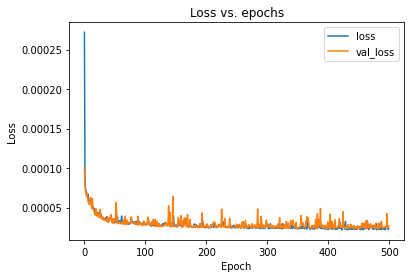

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

## Predict data

In [34]:
y_test_predicted = scaler.inverse_transform(model.predict(x_test_scaled))

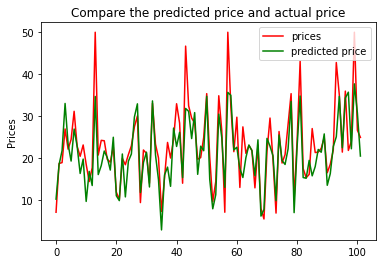

In [35]:
fig, ax = plt.subplots()
x = np.arange(y_test.shape[0])
ax.plot(y_test, label='prices', color='r')
ax.plot(y_test_predicted, label='predicted price', color='g')
ax.set_ylabel('Prices')
ax.set_title("Compare the predicted price and actual price")
ax.legend()